In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [ ]:
train_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_test.csv'), delimiter=',')

img_shape = (28, 28)
img_size = 784

### Generate dataset

In [4]:
def one_hot(n: int, i: int) -> np.ndarray:
    v = np.zeros(n)
    v[i] = 1.0
    return v

In [14]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])
labels_train = train_data[:,0].astype(np.int32)

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])
labels_test = test_data[:,0].astype(np.int32)

### Define activation functions, derivatives and loss functions

In [6]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

def dsigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

def softmax(x: np.ndarray, axis=0, keepdims=True) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y, axis=axis, keepdims=keepdims)

def cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q))

### Define model

In [34]:
class MultilayerPeceptron:
    def __init__(self, n_in: int, n_h: int, n_out: int) -> None:
        self.W1: np.ndarray = np.random.uniform(-0.01, 0.01, (n_in, n_h))
        self.b1: np.ndarray = np.zeros(n_h)

        self.W2: np.ndarray = np.random.uniform(-0.01, 0.01, (n_h, n_out))
        self.b2: np.ndarray = np.zeros(n_out)
    
    @property
    def parameters(self) -> tuple[np.ndarray]:
        return (self.W1, self.b1, self.W2, self.b2)

    def __call__(self, x: np.ndarray)-> np.ndarray:
        if x.ndim == 1:
            x = x.reshape((1, x.size))
        h = sigmoid(x @ self.W1 + self.b1)
        p = softmax(h @ self.W2 + self.b2)
        return p.ravel() if len(p) == 1 else p
    
    def save(self, fp: Path) -> None:
        np.savez(fp, w1=self.W1, b1=self.b1, w2=self.W2, b2=self.b2)

    def load(self, fp: Path) -> None:
        params = np.load(fp)
        self.W1, self.b1 = params['w1'], params['b1']
        self.W2, self.b2 = params['w2'], params['b2']

def calc_loss(model: MultilayerPeceptron, X: np.ndarray, P: np.ndarray) -> float:
    return np.mean([cross_entropy(p,q) for (p,q) in zip(P,model(X))])

def calc_accuracy(model: MultilayerPeceptron, X: np.ndarray, P: np.ndarray) -> float:
    fn = lambda a, b: 1 if np.argmax(a) == np.argmax(b) else 0
    return np.mean([fn(p,q) for (p,q) in zip(P,model(X))])

### SGD algorithm implementation

In [49]:
def train(model: MultilayerPeceptron, X: np.ndarray, Y: np.ndarray, lr, batch_size, max_epoch) -> None:
    n_samples = len(X)
    n_batches = n_samples // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n_samples)
        batches = np.array_split(idxs, n_batches)
        
        for batch in batches:
            U = X[batch] @ model.W1 + model.b1
            H = sigmoid(U)

            dLdy = softmax(H @ model.W2 + model.b2, 1) - Y[batch]
            dLdu = dLdy @ model.W2.T * dsigmoid(U)

            dW2 = np.mean(np.einsum('ij,ik->ijk', H, dLdy), axis=0)
            db2 = np.mean(dLdy, axis=0)

            dW1 = np.mean(np.einsum('ij,ik->ijk', X[batch], dLdu), axis=0)
            db1 = np.mean(dLdu, axis=0)
            
            model.W1 -= lr * dW1
            model.b1 -= lr * db1

            model.W2 -= lr * dW2
            model.b2 -= lr * db2

### Create, train and test model

In [52]:
n_in = 784
n_h = 16
n_out = 10

learning_rate = 0.1
batch_size = 64
max_epoch = 4

model = MultilayerPeceptron(n_in, n_h, n_out)

print(f"untrained loss: {round(calc_loss(model, x_test, y_test), 3)}")
train(model, x_train, y_train, learning_rate, batch_size, max_epoch)
print(f"trained loss: {round(calc_loss(model, x_test, y_test), 3)}")

model_accuracy = calc_accuracy(model, x_test, y_test)
print(f"test set accuracy: {round(model_accuracy * 100, 2)}%")

untrained loss: 9.21
trained loss: 7.703
test set accuracy: 84.2%


### Save, load and test model

In [53]:
fp = Path('D:/Development/Data/tmp/parameters.npz')
model.save(fp)

In [54]:
model = MultilayerPeceptron(n_in, n_h, n_out)
model.load(fp)

In [55]:
model_loss = calc_loss(model, x_test, y_test)
model_accuracy = calc_accuracy(model, x_test, y_test)

print(f"loss: {round(model_loss, 3)}")
print(f"accuracy: {round(model_accuracy * 100, 2)}%")

loss: 7.703
accuracy: 84.2%


### Caclculating Precision, Recall and Accuracy for all digits

In [56]:
counts = {'TP': np.zeros(10),'TN': np.zeros(10),'FP': np.zeros(10),'FN': np.zeros(10)}
labels_guess_test = np.apply_along_axis(np.argmax, 1, model(x_test))

for label_guess, true_label in zip(labels_guess_test, labels_test):
    if label_guess == true_label:
        v = one_hot(10, label_guess)
        counts['TP'] += v
        counts['TN'] += 1-v
    else:
        counts['FP'][label_guess] += 1
        counts['FN'][true_label] += 1

np_counts = np.array(list(counts.values()))

precision = counts['TP'] / (counts['TP'] + counts['FP'])
recall = counts['TP'] / (counts['TP'] + counts['FN'])
accuracy = (counts['TP'] + counts['TN']) / (np.sum(np_counts, axis=0))

print('precision', np.round(precision, 3))
print('recall   ', np.round(recall, 3))
print('accuracy ', np.round(accuracy, 3))

precision [0.939 0.956 0.899 0.868 0.774 0.736 0.933 0.944 0.695 0.725]
recall    [0.905 0.936 0.836 0.819 0.822 0.765 0.886 0.813 0.864 0.758]
accuracy  [0.982 0.986 0.969 0.965 0.954 0.949 0.98  0.972 0.944 0.94 ]


### Visualize parameters

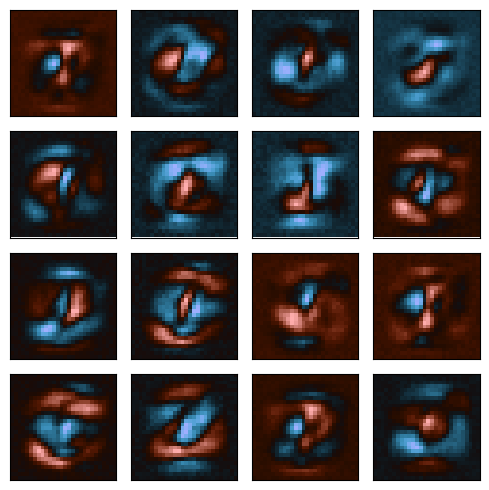

In [57]:
fig, axes = plt.subplots(4,4)
fig.set_figheight(5)
fig.set_figwidth(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    ax.matshow(model.W1[:,i].reshape(img_shape), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

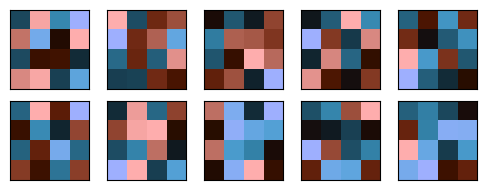

In [58]:
fig, axes = plt.subplots(2,5)
fig.set_figheight(2)
fig.set_figwidth(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    ax.matshow(model.W2[:,i].reshape((4,4)), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()